# Reference
https://pyimagesearch.com/2014/01/27/hobbits-and-histograms-a-how-to-guide-to-building-your-first-image-search-engine-in-python/

https://pyimagesearch.com/2014/12/01/complete-guide-building-image-search-engine-python-opencv/

In [149]:
import numpy  as np
import cv2
import imutils
import pickle
import os
import math

from matplotlib import pyplot as plt
from os import listdir

In [150]:
class ColorDescriptor:
    def __init__(self, bins: list):
        self.bins = bins
        
    def histogram(self, image: np.ndarray, mask: np.ndarray) -> list:
        hist = cv2.calcHist([image], [0, 1, 2], None, self.bins, 
                            [0, 180, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        
        return hist
    
    def describe(self, image: np.ndarray):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        features = []
        
        # center of the image
        h, w = image.shape[:2]
        cx, cy = int(w/2), int(h/2)
        
        # divide the image to 4 rectangle
        # top-left, top-right, bottom-right, bottom-left
        segments = [
            (0, cx, 0, cy),
            (cx, w, 0, cy),
            (cx, w, cy, h),
            (0, cx, cy, h)
        ]

        axes_x, axes_y = int(w * 0.75) // 2, int(h * 0.75) // 2
        ellipse_mask = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.ellipse(ellipse_mask, (cx, cy), (axes_x, axes_y),
                    0, 0, 360, 255, -1)
        
        for start_x, end_x, start_y, end_y in segments:
            # construct corner masks
            corner_mask = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.rectangle(corner_mask, (start_x, start_y), (end_x, end_y), 255, -1)
            # remove corner mask overlap area
            corner_mask = cv2.subtract(corner_mask, ellipse_mask)
            
            hist = self.histogram(image, corner_mask)
            features.extend(hist)
            
        hist = self.histogram(image, ellipse_mask)
        features.extend(hist)
        
        return features
    
class RBGHistogram:
    def __init__(self, bins: list):
        self.bins = bins
    
    def describe(self, image):
        '''
            compute 3D histogram in RGB color space
            then normalize the histogram, so that the image with same content (convert to % rather than number of pixels)
            but either scale larger or smaller will have (roughly) the same histogram
        '''
        hist = cv2.calcHist([image], [0,1,2], None, self.bins, [0,256,0,256,0,256])
        # hist = cv2.calcHist([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)], [0], None, self.bins, [0,256])
        # normalize
        hist /= hist.sum()
        # hist = cv2.normalize(hist, hist)
        
        return hist.flatten()
    
    def image_resize(self, image, width = None, height = None, inter = cv2.INTER_AREA):
        # initialize the dimensions of the image to be resized and
        # grab the image size
        dim = None
        (h, w) = image.shape[:2]

        # if both the width and height are None, then return the
        # original image
        if width is None and height is None:
            return image

        # check to see if the width is None
        if width is None:
            # calculate the ratio of the height and construct the
            # dimensions
            r = height / float(h)
            dim = (int(w * r), height)

        # otherwise, the height is None
        else:
            # calculate the ratio of the width and construct the
            # dimensions
            r = width / float(w)
            dim = (width, int(h * r))

        # resize the image
        resized = cv2.resize(image, dim, interpolation = inter)

        # return the resized image
        return resized
    

class Searcher:
    def __init__(self, index: dict):
        self.index = index
    
    def search(self, query_features: list, limit = 10) -> list:
        results: dict = {}
        
        for k, features in self.index.items():
            distance = self.chi2_distance(features, query_features)
            results[k] = distance
        
        results = sorted([(v, k) for (k, v) in results.items()])
        return results[:limit]
    
    def chi2_distance(self, hist_a, hist_b, eps=1e-10):
        distance = 0.5 * np.sum([
            ((a-b) ** 2) / (a+b+eps) for (a,b) in zip(hist_a, hist_b)
        ])
        
        return distance

    def euclidean_distance(self, point_a, point_b):
        # reference: https://www.geeksforgeeks.org/calculate-the-euclidean-distance-using-numpy/
        sum_sq = np.sum(np.square(point_a - point_b))
        return np.sqrt(sum_sq)
        


In [151]:
query_img = cv2.imread('../resources/search-dataset/214000.jpg')

[INFO] done... indexed 157 images


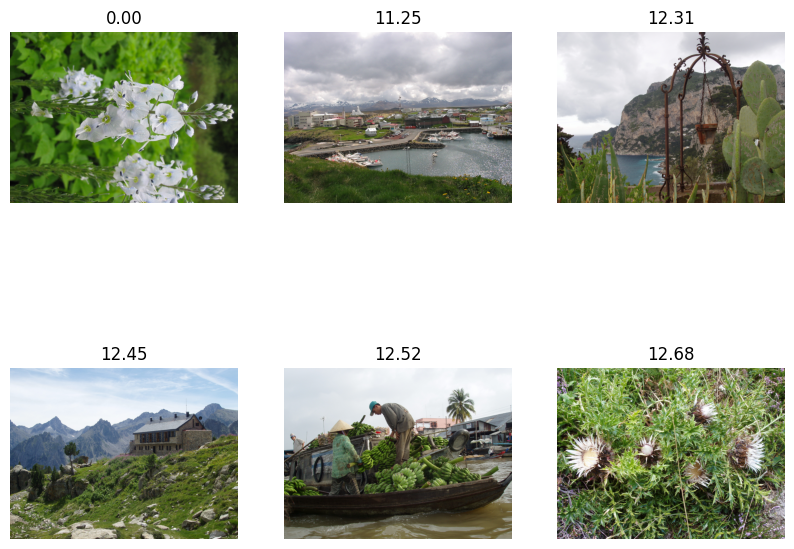

In [152]:
# color
desc = ColorDescriptor([8, 12, 3])
image = cv2.imread('../resources/image_search_sample1.jpg')
index = {}

for path in listdir('../resources/search-dataset/'):
    image = cv2.imread(f"../resources/search-dataset/{path}")
    features = desc.describe(image)
    index[path] = features

f = open('../model/image_search_model2', 'wb')
f.write(pickle.dumps(index))
f.close()

print('[INFO] done... indexed {} images'.format(len(index)))

index = pickle.loads(open('../model/image_search_model2', 'rb').read())
seacher = Searcher(index)

query_feature = desc.describe(query_img)
results = seacher.search(query_feature, 6)

result_imgs = []
for score, img_name in results:
    path = os.path.join('../resources/search-dataset', img_name)
    img = cv2.imread(path)
    result_imgs.append((score, img))
    
col = 3
row = math.ceil(len(result_imgs) / col)
fig, axs = plt.subplots(row, col, figsize=(10,8))
for i, (score, img) in enumerate(result_imgs):
    x =  1 if i >= col else 0
    y = i % col
    axs[x][y].axis(False)
    axs[x][y].set_title("{:.2f}".format(score))
    axs[x][y].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.show()
        

[INFO] done... indexed 157 images


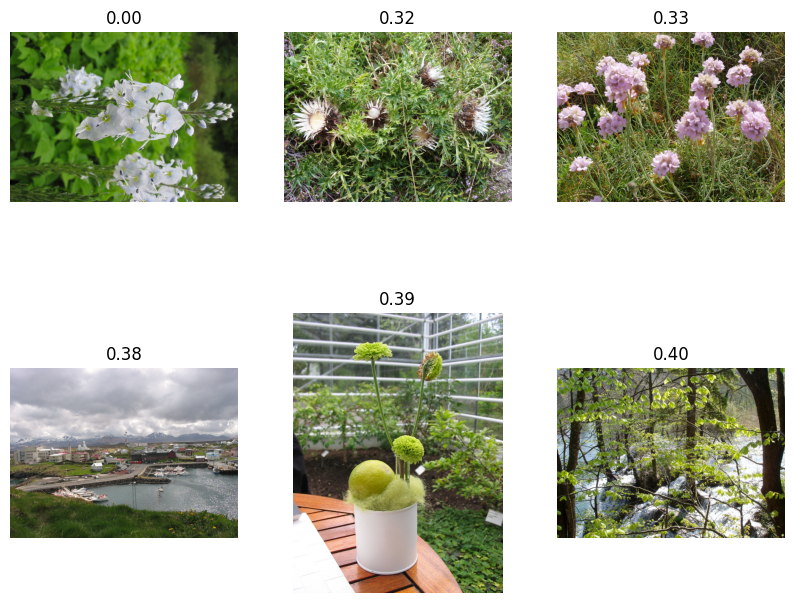

In [153]:
# rgb
desc = RBGHistogram([8, 12, 3])
image = cv2.imread('../resources/image_search_sample1.jpg')
index = {}

for path in listdir('../resources/search-dataset/'):
    image = cv2.imread(f"../resources/search-dataset/{path}")
    features = desc.describe(image)
    index[path] = features

f = open('../model/image_search_model2', 'wb')
f.write(pickle.dumps(index))
f.close()

print('[INFO] done... indexed {} images'.format(len(index)))

index = pickle.loads(open('../model/image_search_model2', 'rb').read())
seacher = Searcher(index)

query_feature = desc.describe(query_img)
results = seacher.search(query_feature, 6)

result_imgs = []
for score, img_name in results:
    path = os.path.join('../resources/search-dataset', img_name)
    img = cv2.imread(path)
    result_imgs.append((score, img))
    
col = 3
row = math.ceil(len(result_imgs) / col)
fig, axs = plt.subplots(row, col, figsize=(10,8))
for i, (score, img) in enumerate(result_imgs):
    x =  1 if i >= col else 0
    y = i % col
    axs[x][y].axis(False)
    axs[x][y].set_title("{:.2f}".format(score))
    axs[x][y].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.show()
        